In [1]:
from PIL import Image,ImageChops,ImageMath
import numpy as np

im = Image.open("cl1.jpg")
b = Image.open("b1.jpg")

### 正常模式（Normal）

默认模式，显示混合色图层（蝴蝶图层）的像素，没有进行任何的图层混合。这意味着基色图层（背景图层）对蝴蝶层没有影响。


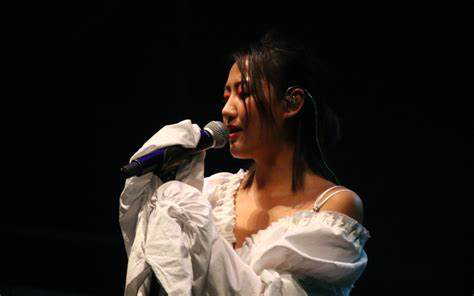

In [20]:
Image.alpha_composite(b.convert('RGBA'), im.convert('RGBA'))

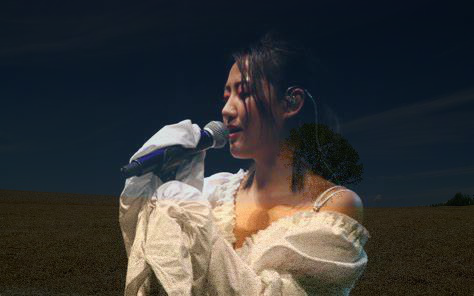

In [23]:
Image.blend(b,im,0.8)

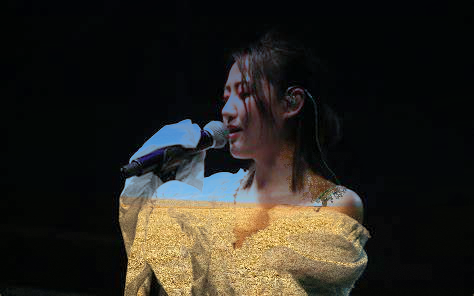

In [28]:
Image.composite(b,im,im.convert('L'))

## 变暗模式

### 变暗（Darken）
变暗模式在混合时，将绘制的颜色与基色之间的亮度进行比较，亮于基色的颜色都被替换，暗于基色的颜色保持不变。在变暗模式中，查看每个通道的颜色信息，并选择基色与混合色中较暗的颜色作为结果色。


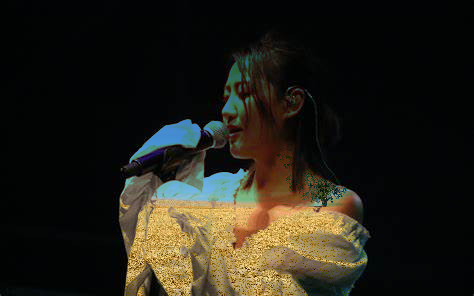

In [76]:
ImageChops.darker(b,im)

### 正片叠底（Multiply）

RGB颜色模式一共有红绿蓝三个颜色通道，数值设置范围为0-255，每个颜色通道的数值越大，表现的颜色就越亮，数值越小颜色越暗，

将基色与混合色相乘然后除于最大的255，结果肯定是图像整体变暗。

当任何颜色与黑色进行正片叠底模式操作时，得到的颜色仍为黑色，因为黑色的像素值为0；当任何颜色与白色进行正片叠底模式操作时，颜色保持不变，因为白色的像素值为255。

变暗不生成新的颜色，而正片叠底则会生成新的颜色。


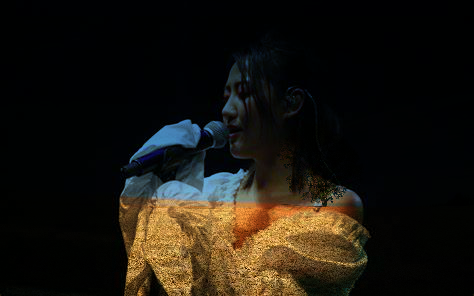

In [77]:
ImageChops.multiply(b,im)

### 颜色加深（Color Burn）

“颜色加深”模式的作用，是在保留了白色的情况下，以增加对比度的方式，使背景图层变暗，再与上方图层混合。“颜色加深”在调整摄影照片时，应用率并不高，只适合处理曝光较亮的照片，而且还要搭配着图层的不透明度使用。当强行处理曝光不足的照片时，就会出现色阶断层的现象。除了白色，“颜色加深”把每一种颜色或者说暗度，都增加了对比度，就是它的特点了。

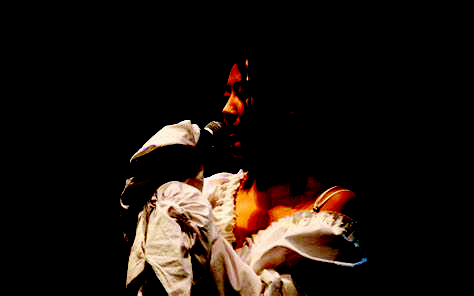

In [96]:
def colorburn(a,b):
    na = np.asarray(a).astype("float") 
    nb = np.asarray(b).astype("float") 
    with np.errstate(divide='ignore'):
        nc = np.where(nb != 0.0, np.maximum(na - ((255.0 - na) * (255.0 - nb) / nb), 0.0), 0.0)
    
    return Image.fromarray(nc.astype("uint8"))

colorburn(im,im)

### 线性加深（Linear Burn）

线性加深模式同样用于查看每个通道的颜色信息，不同的是，它通过降低其亮度使基色变暗来反映混合色。

如果混合色与基色呈白色，混合后将不会发生变化。混合色为黑色的区域均显示在结果色中，而白色的区域消失，这就是线性加深模式的特点。


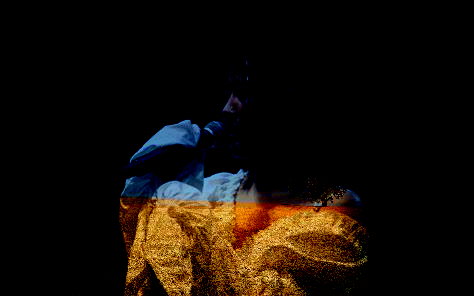

In [78]:
def linearburn(a,b):
    na = np.asarray(a).astype("float") 
    nb = np.asarray(b).astype("float") 
    nc = np.maximum((na + nb - 255.0), 0.0)
    
    return Image.fromarray(nc.astype("uint8"))

linearburn(b,im)

### 深色（Darker Color）

深色混合模式比较好理解。她是通过计算混合色与基色的所有通道的数值，然后选择数值较小的作为结果色。因此结果色只跟混合色或基色相同，不过产生出另外的颜色。白色与基色混合色得到基色，黑色与基色混合得到黑色。深色模式中，混合色与基色的数值是固定的，我们颠倒位置后，混合色出来的结果色是没有变化的。

“混合色”与“基色”图层谁的颜色暗就显示谁，完全替换颜色，不会保留细节（只会有替换，没有融合）


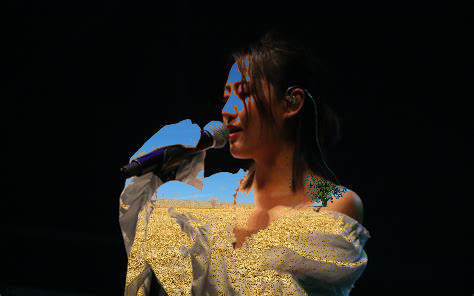

In [79]:
def darkercolor(a,b):
    na = np.asarray(a).astype("float") 
    nb = np.asarray(b).astype("float")

    bt = np.sum(na,axis =2) < np.sum(nb,axis =2)
    nc = np.where(bt.repeat(3).reshape(na.shape),na,nb)
    
    return Image.fromarray(nc.astype("uint8"))

darkercolor(b,im)

## 变亮模式

### 变亮（Lighten）

在该模式与变暗模式相反，是对混合的两个图层相对应区域RGB通道中的颜色亮度值进行比较，取较高的的像素点为混合之后的颜色，使得总的颜色灰度的亮度升高，造成变亮的效果。用黑色合成图像时无作用，用白色时则仍为白色。

（混合图层时，哪个图层的颜色亮就显示哪种颜色，较暗的部分会被舍弃）

用于过滤黑色或比当前图层暗的颜色


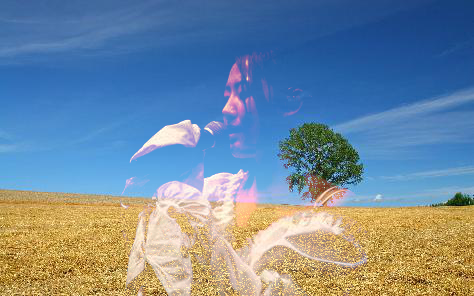

In [80]:
ImageChops.lighter(b,im)

### 滤色（Screen）

它与正片叠底模式相反，将上下两层图层像素颜色的灰度级进行乘法计算，获得灰度级更高的颜色而成为合成后的颜色，图层合成后的效果简单地说是高灰阶的像素显现而低灰阶不显现（即浅色出现，深色不出现），产生的图像更加明亮。

（会完全屏蔽掉所有的纯黑）

因为会屏蔽掉所有纯黑，所以可以用来提亮图层


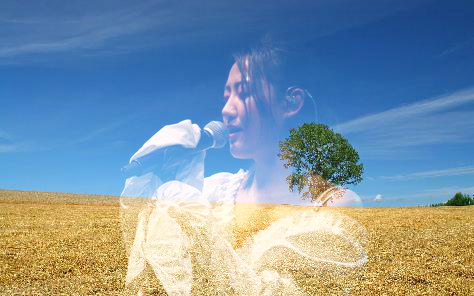

In [81]:
ImageChops.screen(b,im)

### 颜色减淡（Color Dodge）

使用这种模式时，会加亮图层的颜色值，加上的颜色越暗，效果越细腻。与颜色加深刚好相反，通过降低对比度，加亮底层颜色来反映混合色彩。与黑色混合没有任何效果。

（除非都是黑色，否则会越来越亮，用于提亮颜色）


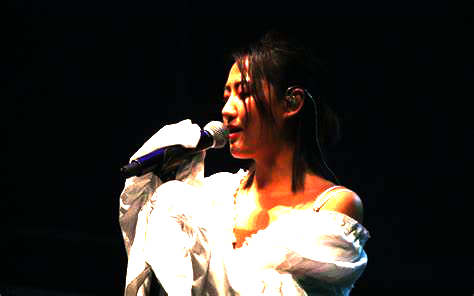

In [97]:
def colourdodge(a, b):
    na = np.asarray(a).astype("float") 
    nb = np.asarray(b).astype("float") 
	
    with np.errstate(divide='ignore'):
        nc = np.where(nb != 255.0, np.minimum(na + (na * nb) / (255.0 - nb), 255.0), 255.0)

    return Image.fromarray(nc.astype("uint8"))

colourdodge(im,im)

### 线性减淡（Linear Dodge）

类似于颜色减淡模式。但是通过增加亮度来使得底层颜色变亮，以此获得混合色彩。与黑色混合没有任何效果。



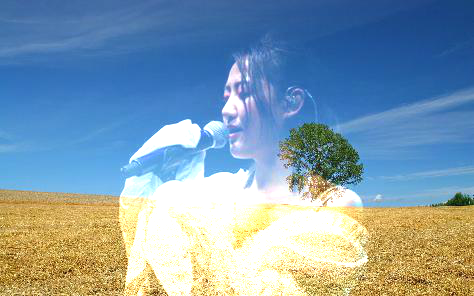

In [83]:
ImageChops.add(b,im)

### 浅色（Lighter Color）

通过计算混合色与基色所有通道的数值总和，哪个数值大就选为结果色。因此结果色只能在混合色与基色中选择，不会产生第三种颜色。与深色模式刚好相反。

谁白（亮）留下谁

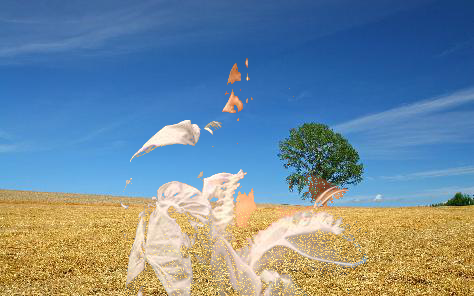

In [84]:
def lightercolor(a,b):
    na = np.asarray(a).astype("float") 
    nb = np.asarray(b).astype("float")

    bt = np.sum(na,axis =2) > np.sum(nb,axis =2)
    nc = np.where(bt.repeat(3).reshape(na.shape),na,nb)
    
    return Image.fromarray(nc.astype("uint8"))

lightercolor(b,im)

## 饱和度模式

### 叠加（Overlay）

叠加模式是根据基色图层的色彩来决定混合色图层的像素是进行正片叠底还是进行滤色，一般来说，发生变化的都是中间色调，高色和暗色区域基本保持不变。

叠加混合模式实际上是正片叠底模式和滤色模式的一种混合模式。该模式是将混合色与基色相互叠加，也就是说底层图像控制着上面的图层，可以使之变亮或变暗。比50%暗的区域将采用正片叠底模式变暗，比50%亮的区域则采用滤色模式变亮。


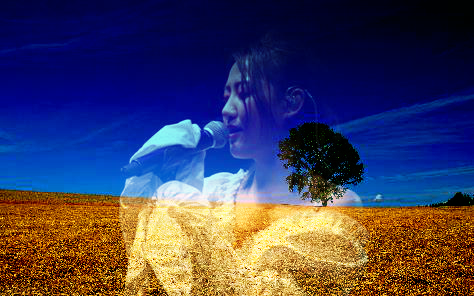

In [85]:
def overlay(a,b):
    na = np.asarray(a).astype("float") 
    nb = np.asarray(b).astype("float") 
    nc = np.where(na <= 128.0, na * nb /128.0, 255.0 - (255.0 -na) * (255.0 - nb) / 128.0 )
    
    return Image.fromarray(nc.astype("uint8"))

overlay(b,im)

### 柔光（Soft Light）

将混合色图层以柔光的方式加到基色图层，当基色图层的灰阶趋于高或低，则会调整图层合成结果的阶调趋于中间的灰阶调，而获得色彩较为柔和的合成效果。

也会去掉中性灰，但不会去掉全部，做到图片适当的提亮，不会过亮


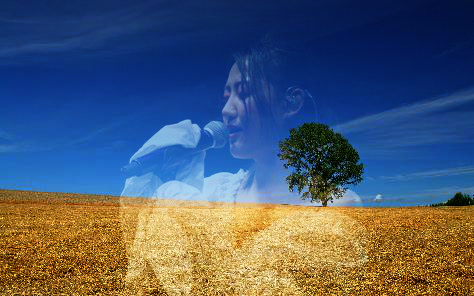

In [87]:
def softlight(a,b):
    na = np.asarray(a).astype("float") 
    nb = np.asarray(b).astype("float") 
    nc = np.where(nb <= 128.0, na * nb /128.0 + np.square(na / 255.0) * (255.0 - 2 * nb),                                                  na * (255.0 - nb) / 128.0 + np.sqrt(na / 255.0) * ( 2* nb - 255.0))
    
    return Image.fromarray(nc.astype("uint8"))

softlight(b,im)

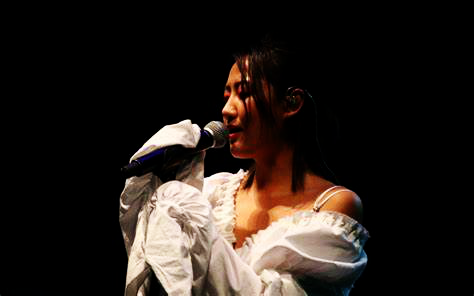

In [92]:
softlight(im,im)

In [ ]:
### 强光（Hard Light）

强光混合模式是正片叠底模式与滤色模式的组合。它可以产生强光照射的效果，根据当前图层颜色的明暗程度来决定最终的效果变亮还是变暗。如果混合色比基色的像素更亮一些，那么结果色更亮；如果混合色比基色的像素更暗一些，那么结果色更暗。这种模式实质上同柔光模式相似，区别在于它的效果要比柔光模式更强烈一些。在强光模式下，当前图层中比50%灰色亮的像素会使图像变亮；比50%灰色暗的像素会使图像变暗，但当前图层中纯黑色和纯白色将保持不变。



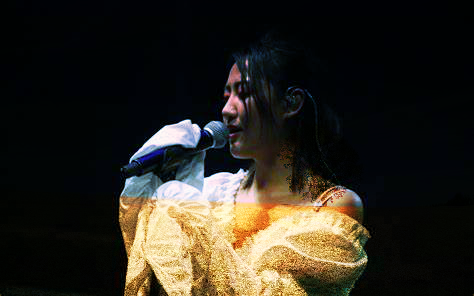

In [91]:
def hardlight(a,b):
    na = np.asarray(a).astype("float") 
    nb = np.asarray(b).astype("float") 
    nc = np.where(nb <= 128.0, na * nb /128.0 , 255 - (255.0 - na) * (255.0 - nb) /128.0)
    
    return Image.fromarray(nc.astype("uint8"))

hardlight(b,im)

### 亮光（Vivid Light）

调整对比度以加深或减淡颜色，取决于混合层图像的颜色分布。如果混合层颜色（光源）亮度高于50%灰，图像将被降低对比度并且变亮；如果混合层颜色（光源）亮度低于50%灰，图像会被提高对比度并且变暗。


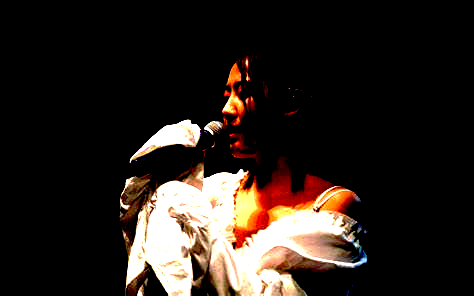

In [99]:
def cb(a,b):
    with np.errstate(divide='ignore'):
        return np.where(b != 0.0, np.maximum(a - ((255.0 - a) * (255.0 - b) / b), 0.0), 0.0)
    
def cd(a, b):
    with np.errstate(divide='ignore'):
        return np.where(b != 255.0, np.minimum(a + (a * b) / (255.0 - b), 255.0), 255.0)



def vividlight(a, b):
    na = np.asarray(a).astype("float") 
    nb = np.asarray(b).astype("float") 
    nc = np.where(nb <= 128.0, cb(na , nb *2) , cd(na , 2 * (nb - 128.0)))
    
    return Image.fromarray(nc.astype("uint8"))

vividlight(im,im)


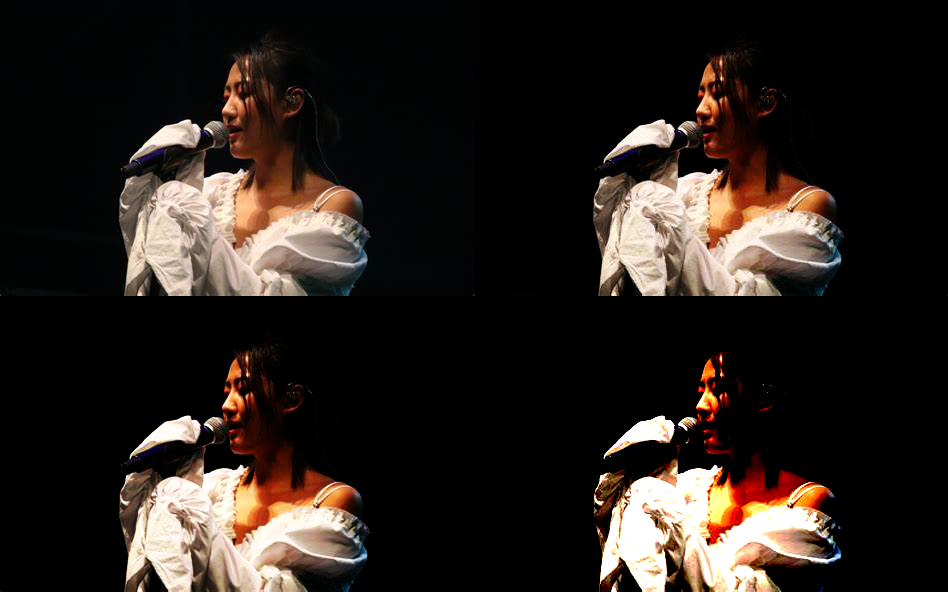

In [101]:
w, h = im.size

img = Image.new("RGB", (w*2, h*2))

img.paste(im, (0, 0))
img.paste(softlight(im,im), (w, 0))
img.paste(hardlight(im,im) , (0, h))
img.paste(vividlight(im,im) , (w, h))
img

### 线性光（Linear Light）

线性光混合模式是线性减淡模式与线性加深模式的组合。线性光模式通过增加或降低当前图层颜色亮度来加深或减淡颜色。如果当前图层中的像素比50%灰色亮，可通过增加亮度使图像变亮；如果当前图层中的像素比50%灰色暗，则通过减小亮度使图像变暗。与强光模式相比，线性光模式可使图像产生更高的对比度，也会使更多的区域变为黑色或白色。

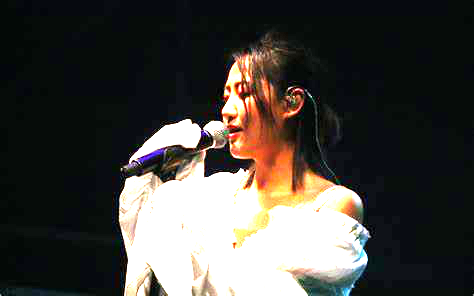

In [105]:
def linearlight(a, b):
    na = np.asarray(a).astype("float") 
    nb = np.asarray(b).astype("float") 
    nc = np.clip(na + 2 * nb ,0.0,255.0)
    
    return Image.fromarray(nc.astype("uint8"))

linearlight(im,im)

### 点光（Pin Light）

点光混合模式其实就是根据当前图层颜色来替换颜色。若当前图层颜色比50%的灰亮，则比当前图层颜色暗的像素被替换，而比当前图层颜色亮的像素不变；若当前图层颜色比50%的灰暗，则比当前图层颜色亮的像素被替换，而比当前图层颜色暗的像素不变。


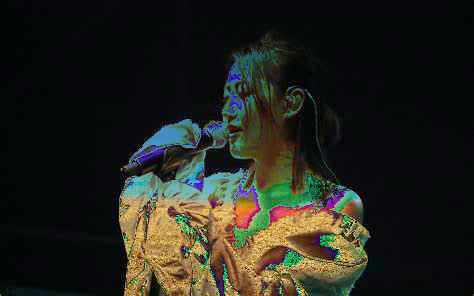

In [109]:
def pinlight(a, b):
    na = np.asarray(a).astype("float") 
    nb = np.asarray(b).astype("float") 
    nc = np.where(nb <= 128.0, np.minimum(na ,2 * nb) , np.minimum(na , 2 * nb -255.0))
    
    return Image.fromarray(nc.astype("uint8"))

pinlight(b,im)

### 实色混合（Hard Mix）

实色混合是把混合色颜色中的红、绿、蓝通道数值，添加到基色的RGB值中。结果色的R、G、B通道的数值只能是255或0。因此结构色只有一下八种可能：红、绿、蓝、黄、青、洋红、白、黑。由此看以看出结果色是非常纯的颜色。


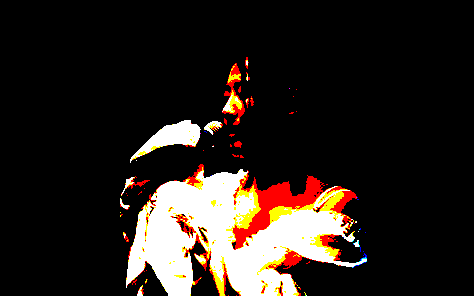

In [111]:
def hardmix(a, b):
    na = np.asarray(a).astype("float") 
    nb = np.asarray(b).astype("float") 
    nc = np.where(na + nb >= 255.0, 255.0 , 0.0)
    
    return Image.fromarray(nc.astype("uint8"))

hardmix(im,im)

## 差集模式

### 差值（Difference）

差值混合模式将混合色与基色的亮度进行对比，用较亮颜色的像素值减去较暗颜色的像素值，所得差值就是最后效果的像素值。

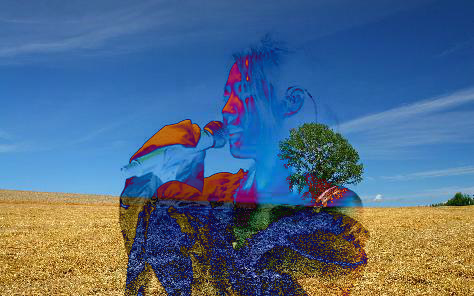

In [112]:
ImageChops.difference(b,im)

### 排除（Exclusion）

排除混合模式与差值模式相似，但排除模式具有高对比和低饱和度的特点，比差值模式的效果要柔和，明亮。白色作为混合色时，图像反转基色而呈现；黑色作为混合色时，图像不发生变化。

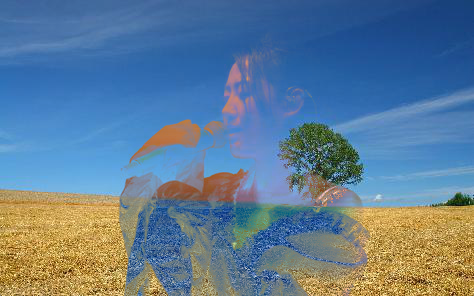

In [115]:
def exclusion(a, b):
    na = np.asarray(a).astype("float") 
    nb = np.asarray(b).astype("float") 
    nc = na + nb - na * nb /128.0
    
    return Image.fromarray(nc.astype("uint8"))

exclusion(b,im)

### 减去（Subtract）

减去模式的作用是查看各通道的颜色信息，并从基色中减去混合色。如果出现负数就归为零。与基色相同的颜色混合得到黑色；白色与基色混合得到黑色；黑色与基色混合得到基色。

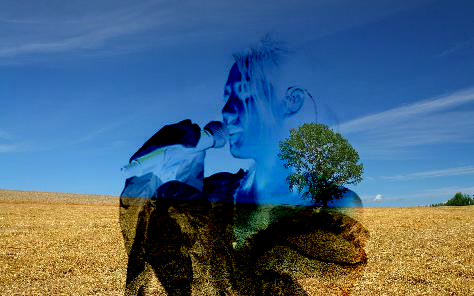

In [117]:
ImageChops.subtract(b,im)

### 划分（Divide）

划分混合模式是查看每个通道的颜色信息，并用基色分割混合色。基色数值大于或等于混合色数值，混合出的颜色为白色。基色数值小于混合色，结果色比基色更暗。因此结果色对比非常强。白色与基色混合得到基色，黑色与基色混合得到白色。

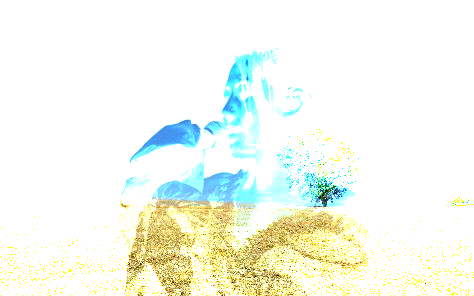

In [126]:
def divide(a, b):
    na = np.asarray(a).astype("float") 
    nb = np.asarray(b).astype("float") 
    nc = np.clip(np.where(nb!=0.0 , 255.0 * na / nb,255.0),0.0,255.0)
    
    return Image.fromarray(nc.astype("uint8"))

divide(b,im)

## 颜色模式

### 色相（Hue）

合成时，用混合图层的色相值去替换基层图像的色相值，而饱和度与亮度不变。决定生成颜色的参数包括：基层颜色的明度与饱和度，混合层颜色的色相。(这里用到的色相、饱和度、明度也是一种颜色模式，也称作：HSB模式。)

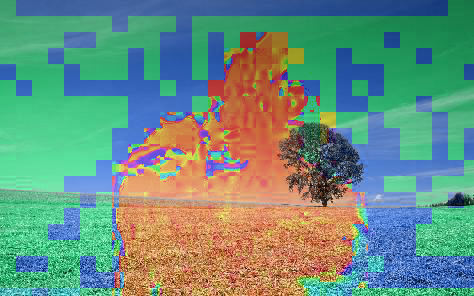

In [9]:
def hue(a,b):
    _,s,v = a.convert('HSV').split()
    h,_,_ = b.convert('HSV').split()
    return Image.merge('HSV',(h,s,v)).convert('RGB')

hue(b,im)

### 饱和度（Saturation）

用混合图层的饱和度去替换基层图像的饱和度，而色相值与亮度不变。决定生成颜色的参数包括：基层颜色的明度与色相，混合层颜色的饱和度。饱和度只控制颜色的鲜艳程度，因此混合色只改变图片的鲜艳度，不能影响颜色。

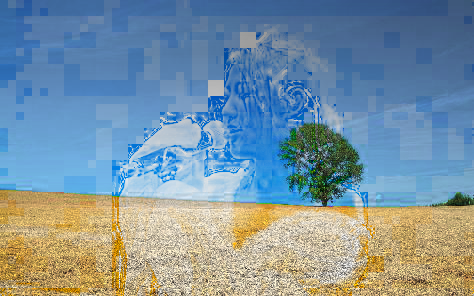

In [10]:
def saturation(a,b):
    h,_,v = a.convert('HSV').split()
    _,s,_ = b.convert('HSV').split()
    return Image.merge('HSV',(h,s,v)).convert('RGB')

saturation(b,im)

### 颜色（Color）

用混合图层的色相值与饱和度替换基层图像的色相值和饱和度，而亮度保持不变。决定生成颜色的参数包括：基层颜色的明度，混合层颜色的色相与饱和度。这种模式下混合色控制整个画面的颜色，是黑白图片上色的绝佳模式，因为这种模式下会保留基色图片也就是黑白图片的明度。

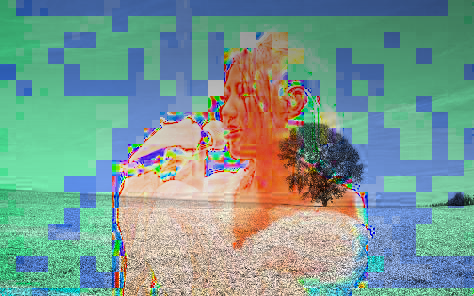

In [14]:
def color(a,b):
    _,_,v = a.convert('HSV').split()
    h,s,_ = b.convert('HSV').split()
    return Image.merge('HSV',(h,s,v)).convert('RGB')

color(b,im)

### 明度（Luminosity）

用当前图层的亮度值去替换下层图像的亮度值，而色相值与饱和度不变。决定生成颜色的参数包括：基层颜色的色调与饱和度，混合层颜色的明度。跟颜色模式刚好相反，因此混合色图片只能影响图片的明暗度，不能对基色的颜色产生影响，黑、白、灰除外。

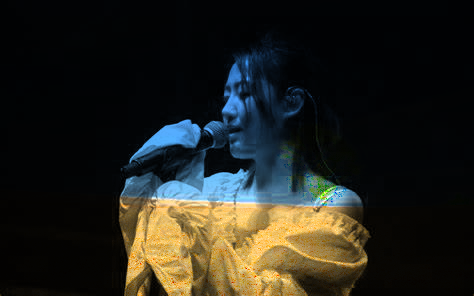

In [15]:
def luminosity(a,b):
    h,s,_ = a.convert('HSV').split()
    _,_,v = b.convert('HSV').split()
    return Image.merge('HSV',(h,s,v)).convert('RGB')

luminosity(b,im)

In [26]:
na = np.asarray(im).astype("float") 
nb = np.asarray(b).astype("float") 


In [18]:
na[0,0]

array([1., 3., 2.])

In [39]:
bna = np.sum(na,axis =2) < np.sum(nb,axis =2)

In [57]:
bna=np.array([[True,True],[True,False]])

In [58]:
bbb = bna.repeat(3).reshape(bna.shape + (3,))

In [59]:
bbb

array([[[ True,  True,  True],
        [ True,  True,  True]],

       [[ True,  True,  True],
        [False, False, False]]])

In [51]:
bna.shape + (3,)

(296, 474, 3)

In [53]:
nc = np.where( bbb,na,nb)

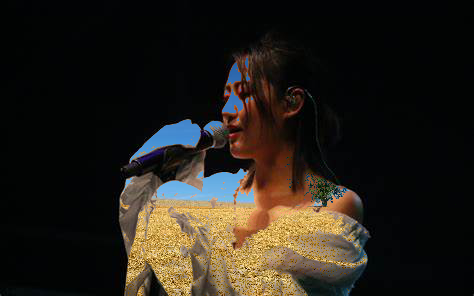

In [54]:
Image.fromarray(nc.astype("uint8"))
